In [1]:
"""
This notebook explores, cleans, and models Steam game data previously collected.
"""

'\nThis notebook explores, cleans, and models Steam game data previously collected.\n'

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/steam_games_extract.csv")

df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1997 entries, 0 to 1996
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1997 non-null   object 
 1   is_free           1997 non-null   bool   
 2   release_year      1997 non-null   int64  
 3   recommendations   1712 non-null   float64
 4   metacritic_score  488 non-null    float64
 5   genres            1997 non-null   object 
 6   app_id            1997 non-null   int64  
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 95.7+ KB


,name,is_free,release_year,recommendations,metacritic_score,genres,app_id
0,Counter-Strike 2,True,2012,4868989.0,NaN,"['Action', 'Free To Play']",730
1,Quarantine Zone: The Last Check,False,2026,873.0,NaN,"['Indie', 'Simulation', 'Strategy']",3419520
2,Steam Deck,False,2025,NaN,NaN,[],1675200
3,ARC Raiders,False,2025,215125.0,NaN,['Action'],1808500
4,PUBG: BATTLEGROUNDS,True,2017,1754636.0,NaN,"['Action', 'Adventure', 'Massively Multiplayer...",578080


In [3]:
df.isnull().sum()

name                   0
is_free                0
release_year           0
recommendations      285
metacritic_score    1509
genres                 0
app_id                 0
dtype: int64

In [4]:
df.describe()


,release_year,recommendations,metacritic_score,app_id
count,1997.000000,1.712000e+03,488.000000,1.997000e+03
mean,2022.103155,4.340034e+04,81.836066,1.919769e+06
std,3.785900,1.627158e+05,6.590530,1.154572e+06
min,1998.000000,1.010000e+02,51.000000,1.000000e+01
25%,2020.000000,1.337500e+03,78.000000,9.858100e+05
50%,2024.000000,7.001500e+03,82.000000,1.850570e+06
75%,2025.000000,3.072050e+04,86.000000,2.827200e+06
max,2026.000000,4.868989e+06,97.000000,4.318180e+06


In [5]:
df["recommendations"].value_counts()

recommendations
479.0       5
102.0       5
150.0       4
110.0       4
285.0       3
           ..
120411.0    1
89186.0     1
23016.0     1
133036.0    1
324.0       1
Name: count, Length: 1521, dtype: int64

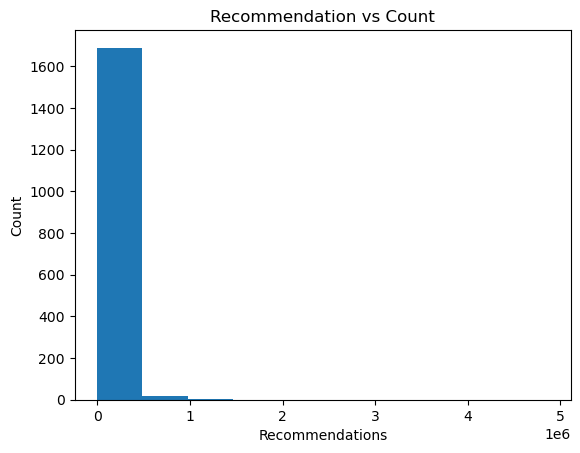

In [6]:
import matplotlib.pyplot as plt

plt.hist(df["recommendations"])

plt.xlabel("Recommendations")
plt.ylabel("Count")
plt.title("Recommendation vs Count")

plt.show()

In [7]:
"""
Based of the information in describe and the histogram above, we can see that the data is heavily skewed right. We have a mean value that is significantly higher than our median, and there are huge jumps at each quartile 
"""

'\nBased of the information in describe and the histogram above, we can see that the data is heavily skewed right. We have a mean value that is significantly higher than our median, and there are huge jumps at each quartile \n'

In [8]:
has_metacritic = df["metacritic_score"].notna()
has_recommendations = df["recommendations"].notna()

print(has_metacritic.value_counts())
print(has_recommendations.value_counts())

metacritic_score
False    1509
True      488
Name: count, dtype: int64
recommendations
True     1712
False     285
Name: count, dtype: int64


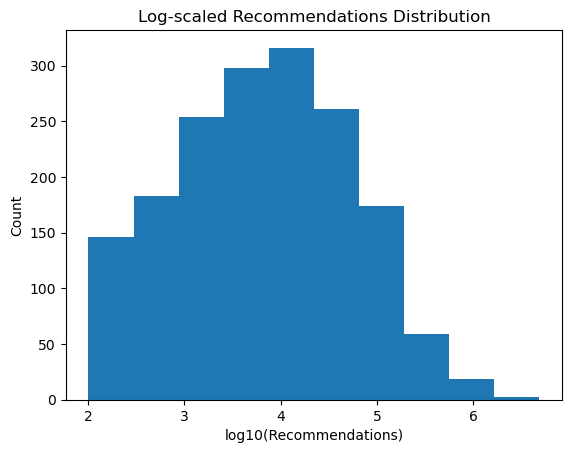

In [9]:
df = df[df["recommendations"].notna()].copy()
df["log_recommendations"] = np.log10(df["recommendations"])

plt.hist(df["log_recommendations"])
plt.xlabel("log10(Recommendations)")
plt.ylabel("Count")
plt.title("Log-scaled Recommendations Distribution")
plt.show()

#Below since this is in log, 1 = 1 recommendations, 2 = 100 recommendations, 3 = 1000 recommmendations, 4 = 10,000, 5=100,000


In [ ]:
#We want a frame of referrence so we calculate the mean as the baseline, because the mean is the value that minimizes average error when you predict a constant - which is not a good number to use for oru calculations but is a good reference because its bad to use
#Our actual model must beat this score
baseline = df["log_recommendations"].mean()
baseline

np.float64(3.8154825944798847)

In [ ]:
from sklearn.metrics import mean_absolute_error
#MAE is actual value - predicted value, so "on average, how wrong are my prediction" - we are 5.6x (we get this from log^0.75) off so we want to reduce this error in out model
y_true = df["log_recommendations"]
#Below is saying "Create a vector of predictions, one per row, equal to the baseline"
x_pred = np.full(len(df), baseline)

#Below is saying "predict the same value for every game"
mean_absolute_error(y_true, x_pred)

0.7491145433585855

In [13]:
#Next we will add one feature to see what effect these will have, we will start with release_year since older games have more time to accumulate recommendations
#Start with clean dataset
model_df = df[df["log_recommendations"].notna() & df["release_year"].notna()].copy()

model_df.shape

(1712, 8)

In [16]:
from sklearn.linear_model import LinearRegression
# we will perform linear regression by first defining x and y
x = model_df[["release_year"]]
y = model_df["log_recommendations"]

model = LinearRegression()
model.fit(x,y)


,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [ ]:
from sklearn.metrics import mean_absolute_error
#Evaluate against the same MAE metric
#y_pred is saying " using the line we just learned above, predict log_recommendations for every game based only on its release_year"
y_pred = model.predict(x)
#Below is saying "predict a different value for each game based on release year"
mae = mean_absolute_error(y, y_pred)

mae

0.666418107168826

In [18]:
model.coef_, model.intercept_


(array([-0.10017894]), np.float64(206.3580504615943))

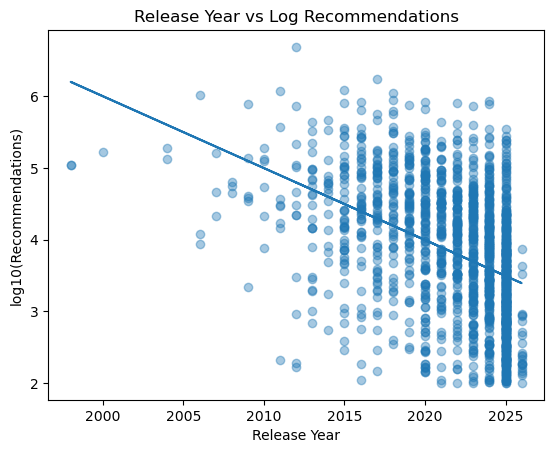

In [ ]:
#The above means log_recommendations = -1.00x + 206.36
#The negative tells us the newer the game is the less recommendations it has, so 10^-1.00 = 0.79 which means every year there are about 21% less recommendations
#We'll plot a regression next
import matplotlib.pyplot as plt

plt.scatter(
    df["release_year"],
    df["log_recommendations"],
    alpha=0.4
)
plt.plot(
    df["release_year"],
    y_pred
)

plt.xlabel("Release Year")
plt.ylabel("log10(Recommendations)")
plt.title("Release Year vs Log Recommendations")
plt.show()



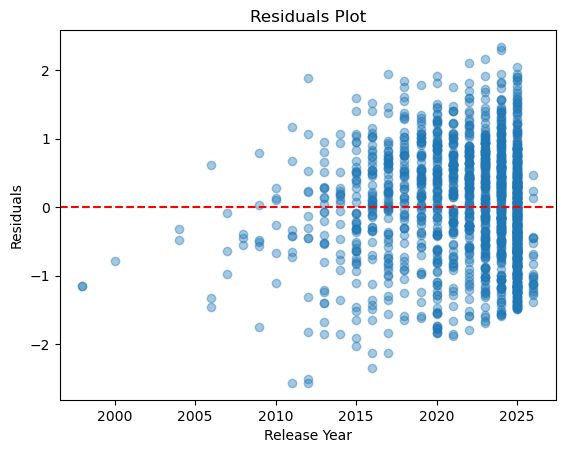

In [ ]:
#We create and plot residuals to show how far off our predictions are. Ideally we want as close to 0
residuals = df["log_recommendations"] - y_pred

plt.scatter(df["release_year"], residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')  # horizontal line at 0
plt.xlabel("Release Year")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()


In [ ]:
#Since there is randomness and no patterns to the above residuals, it means our model is behaving properly
#We will next look at R² to see how much variance is explained in log_recommendations - 1 is strong fit 0 is weak fit
from sklearn.metrics import r2_score

r2 = r2_score(df["log_recommendations"], y_pred)
print(f"R²: {r2:.3f}")

R²: 0.186


In [ ]:
#The above score catches a weak trend as it means that my model only explains 18.6% of the variance in log_recommendations
